## Fit autocovariance

Objective : Estimate tides paramters by fitting a model to Eulerian and Lagrangian binned covariance of the demodulated velocity field

Several parameters of the fitting method can be testing.
Here we focus on a least-square method.

1) Basic method :

Model : $\tilde V e^{-\tau/\tilde T}cos(\omega\tau)$ ; with $\tilde V$ the variance, $\tilde T$ the incoherence timescale and $\omega = \frac{\omega_{S2}-\omega_{M2}}{2}$ fixed the spring neap cycle frequency over 2 (oscilations caused by demodulation)

No bounds, no first guess for the estimates, same weight at all timelag

2) Bounds imposed

3) More weight on the shortest timelags (20days) and a lot on the first. First guess for $\tilde V$ fixed at the autocovariance at timelag 0

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [3]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [4]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [5]:
def y_fit(tau,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau)

In [13]:
#root_path = '/home/datawork-lops-osi/equinox/jetn/'
root_path = '/Users/zcaspar/codes/mit4320/'
file_E = root_path +'binned_Ecov_uu_dl2.nc'
file_L = root_path +'binned_Lcov_uu_dl2_flag10.nc'
file_L_T80 = root_path +'binned_Lcov_uu_dl2_flag10_T80.nc'
#path = '/Users/zcaspar/codes/Diagnostics/'+run#local
dsE = xr.open_dataset(file_E)
dsL = xr.open_dataset(file_L)
dsL_80 = xr.open_dataset(file_L_T80)

#### Plot autocovariance

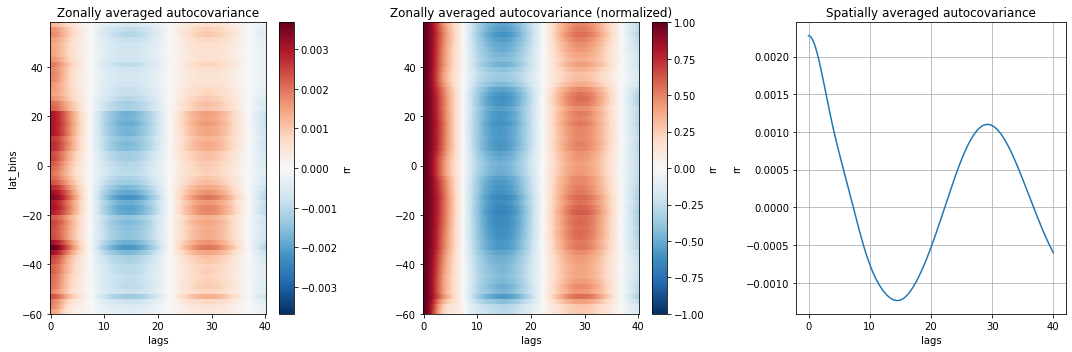

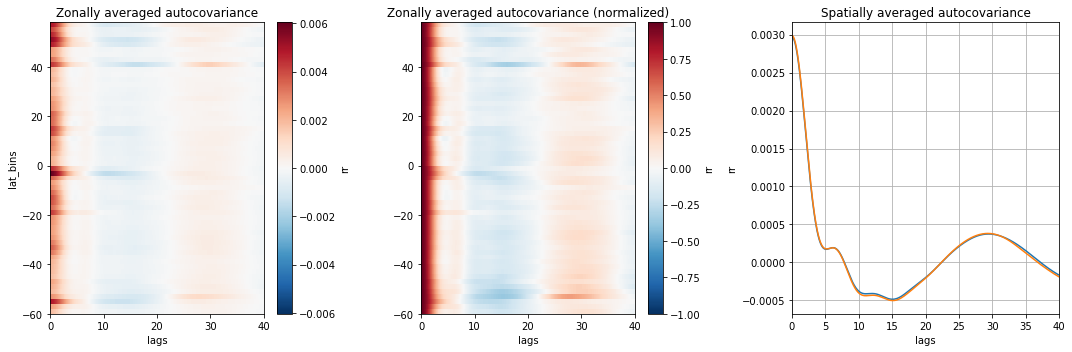

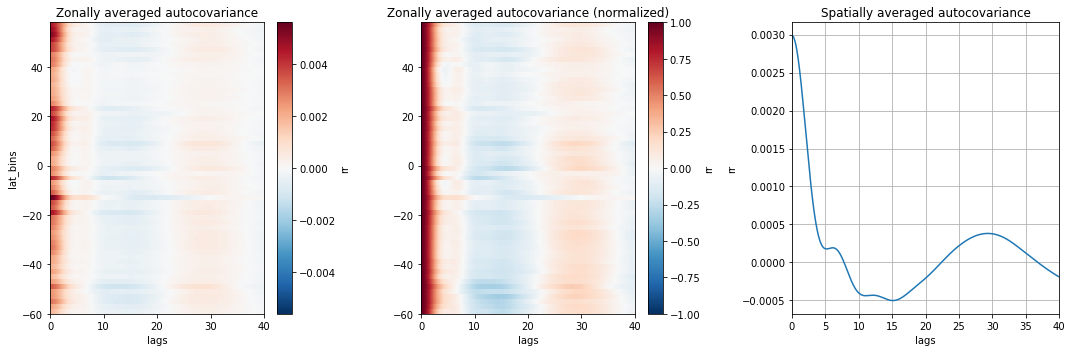

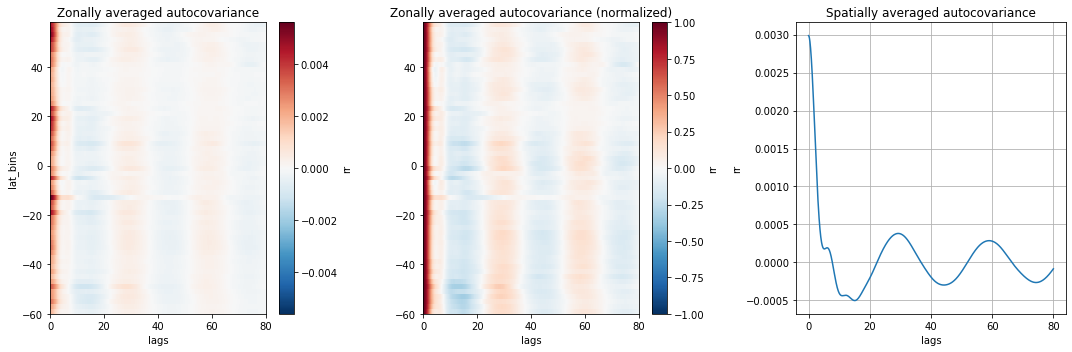

In [14]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
dsE.rr.mean('lon_bins').plot(ax=axs[0],y='lat_bins');axs[0].set_title('Zonally averaged autocovariance')
(dsE.rr.mean('lon_bins')/dsE.rr.mean('lon_bins').isel(lags=0)).plot(ax=axs[1],y='lat_bins');
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsE.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2]);
#dsL_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2],xlim=(0,40));
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()

fig,axs = plt.subplots(1,3,figsize=(15,5))
dsL.rr.mean('lon_bins').plot(ax=axs[0]);axs[0].set_title('Zonally averaged autocovariance')
(dsL.rr.mean('lon_bins')/dsL.rr.mean('lon_bins').isel(lags=0)).plot(ax=axs[1]);
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsL.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2]);
dsL_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2],xlim=(0,40));
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()

fig,axs = plt.subplots(1,3,figsize=(15,5))
dsL_80.rr.mean('lon_bins').plot(ax=axs[0],xlim=(0,40));axs[0].set_title('Zonally averaged autocovariance')
(dsL_80.rr.mean('lon_bins')/dsL_80.rr.mean('lon_bins').isel(lags=0)).plot(ax=axs[1],xlim=(0,40));
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsL_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2],xlim=(0,40));
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()

fig,axs = plt.subplots(1,3,figsize=(15,5))
dsL_80.rr.mean('lon_bins').plot(ax=axs[0]);axs[0].set_title('Zonally averaged autocovariance')
(dsL_80.rr.mean('lon_bins')/dsL_80.rr.mean('lon_bins').isel(lags=0)).plot(ax=axs[1]);
axs[1].set_title('Zonally averaged autocovariance (normalized)')
dsL_80.rr.mean(['lon_bins','lat_bins']).plot(ax=axs[2]);
axs[2].set_title('Spatially averaged autocovariance')
axs[1].set_ylabel('')
axs[2].grid();
fig.tight_layout()



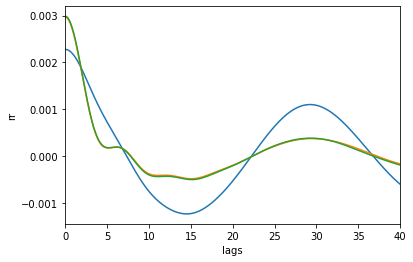

In [15]:
dsE.rr.mean(['lat_bins','lon_bins']).plot()
dsL.rr.mean(['lat_bins','lon_bins']).plot()
dsL_80.rr.mean(['lat_bins','lon_bins']).plot(xlim=(0,40))

In [16]:
# Area of interest
bbox_cal = [-125,35] #california
bbox_med = [4,40] # mediterranean sea
bbox_nwa = [115,-15] # North-west Australia
bbox_nea = [160,-15] # North-west Australia
bbox_swa = [120,-40] # South-west Australia
#bbox_neh = [-160, 35] # North-east Hawaii
bbox_eq = [-125,0] #equator
bbox_atl = [-10,-20]

boxes = {'California':bbox_cal,'North-Eat Australia':bbox_nea,'Mediterranean sea':bbox_med,
         'South atlantic ridge':bbox_atl}

Text(0.5, 0.98, 'Lagrangian autocovariance')

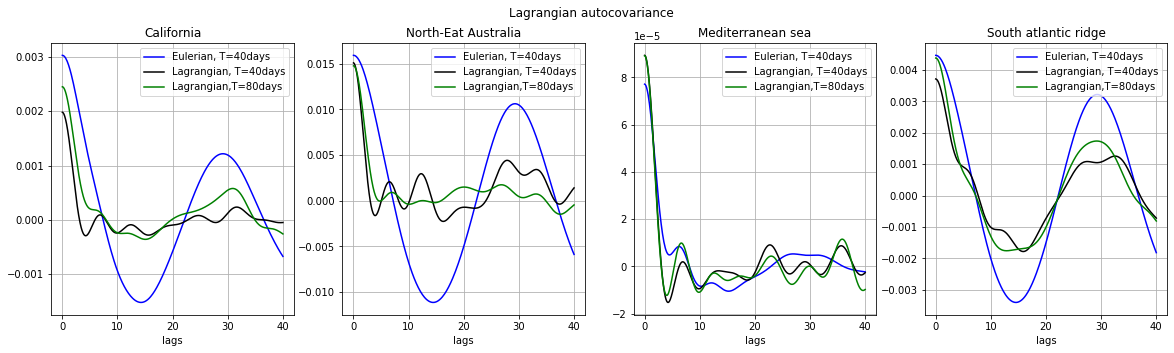

In [17]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='b',label='Eulerian, T=40days')
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Lagrangian, T=40days')
    dsL_80.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).sel(lags=slice(0,40)).plot(ax=ax,c='g',label='Lagrangian,T=80days')
#    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
#                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend()
fig.suptitle('Lagrangian autocovariance')

Text(0.5, 0.98, 'Lagrangian autocovariance')

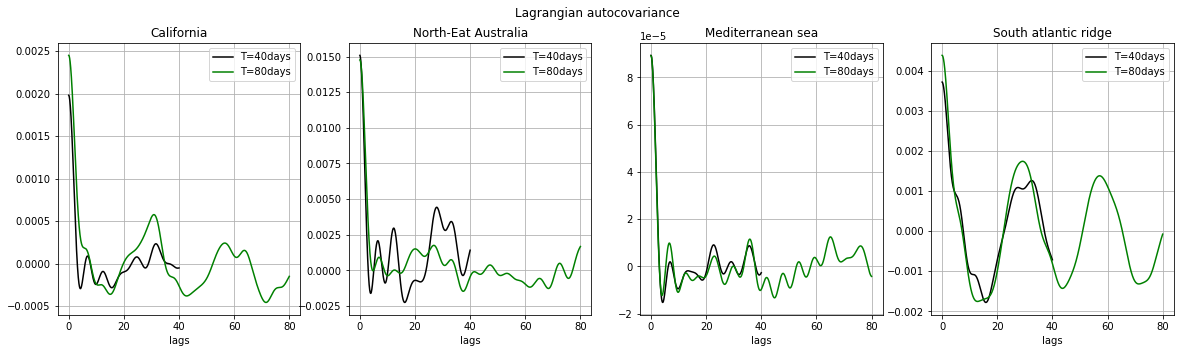

In [18]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='T=40days')
    dsL_80.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='g',label='T=80days')
#    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
#                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend()
fig.suptitle('Lagrangian autocovariance')

In [19]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag

In [20]:
def fit_function(y,t=None,myfunc=None,first_guess='free',bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    sig = signature(myfunc)
    len_sig = len(sig.parameters.keys())
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit
def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [21]:
dsE = dsE.where(dsE.rr.isel(lags=0)>0)

In [22]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [23]:
dsL = dsL.isel(lags=slice(0,None,3))
dsL_80 = dsL_80.isel(lags=slice(0,None,3))

In [24]:
dsL_out = wrapper(dsL,'rr',y_fit,tau,bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [25]:
tau80 = np.arange(0,dsL_80.lags.max()+dt,dt)
dsL_out_80 = wrapper(dsL_80,'rr',y_fit,tau80,bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [26]:
import cartopy.crs as ccrs
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bins',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,
           cbar_kwargs={'fraction':0.02})
    ax.gridlines(draw_labels=True)
    return fig,ax

Text(0.5, 1.0, 'Estimated Lagrangian incoherence timescale (1°x1° bins)')

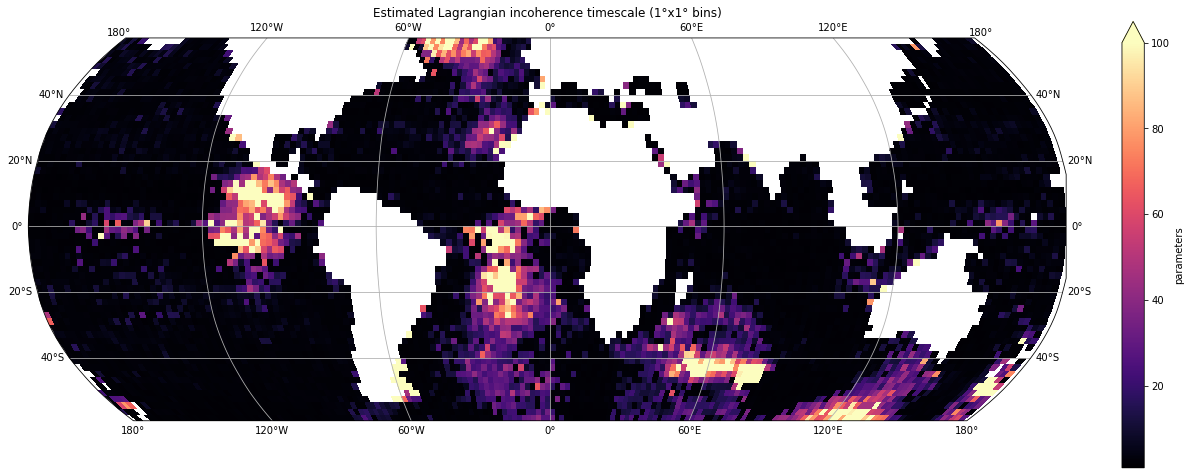

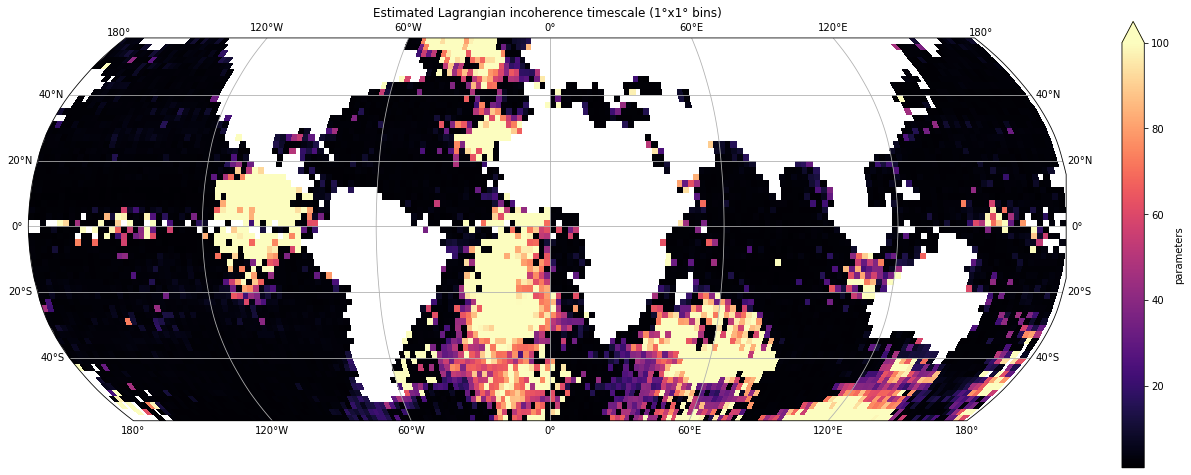

In [27]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out_80.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

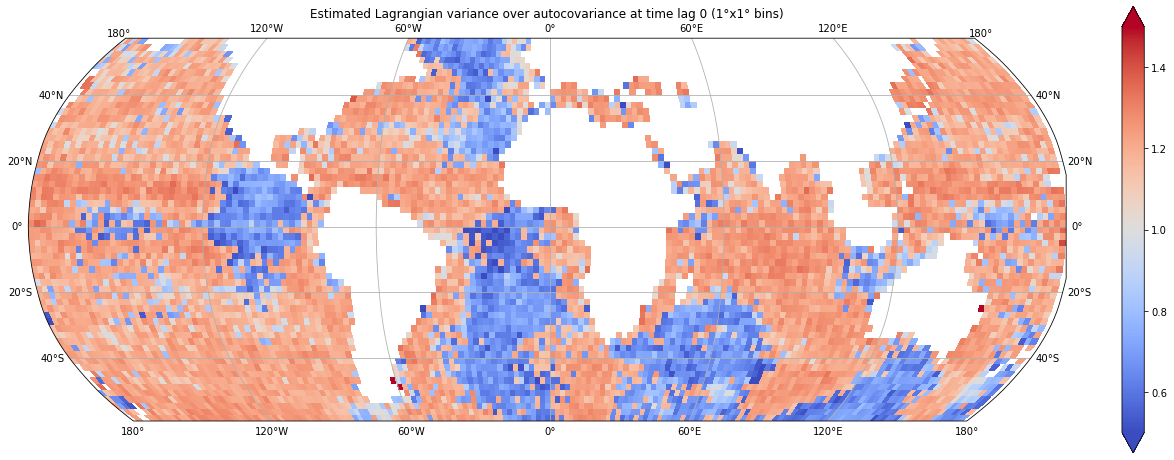

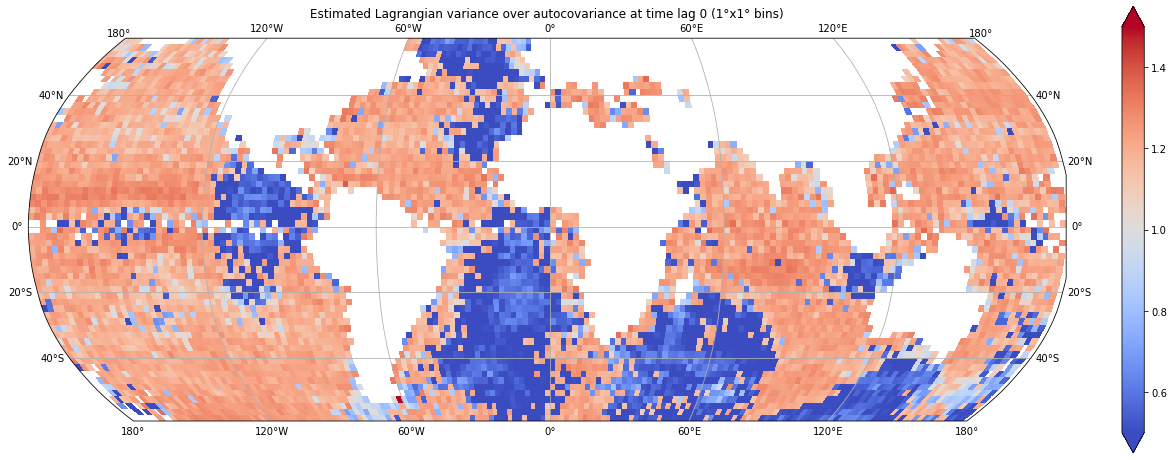

In [28]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out_80.sel(param = 'V').parameters/dsL_80.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

In [29]:
#dsE = dsE.where(dsE.rr.isel(lags=0)>0)
dsL = dsL.where(dsL.rr.isel(lags=0)>0)
dsL = dsL.where(dsL.rr.isel(lags=0)>0)

In [30]:
dsE['rr_norm'] = dsE.rr/dsE.rr.isel(lags=0)
dsL['rr_norm'] = dsL.rr/dsL.rr.isel(lags=0)

In [31]:
dsE_out['rr_norm'] = dsE_out.rr/dsE_out.rr.isel(lags=0)
dsL_out['rr_norm'] = dsL_out.rr/dsL_out.rr.isel(lags=0)

Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

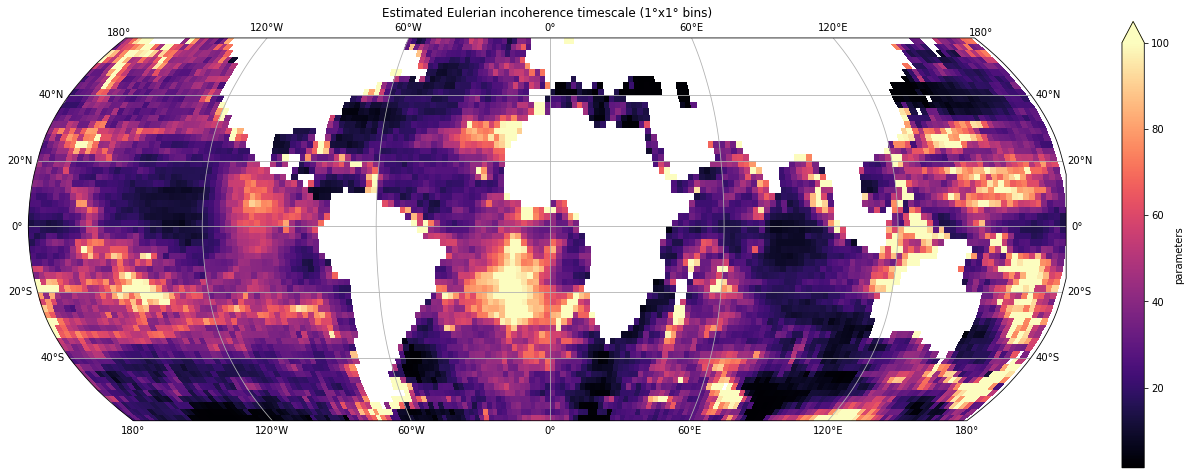

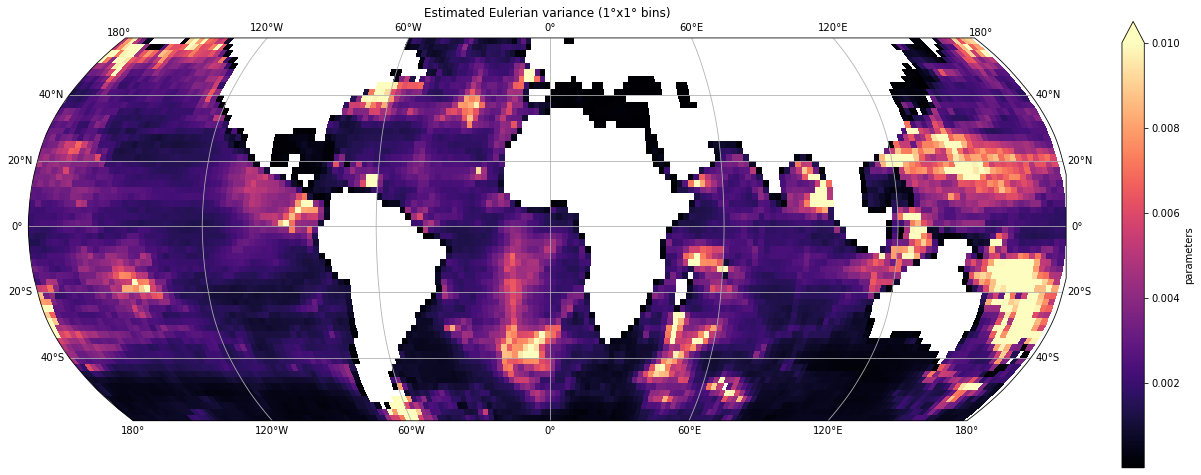

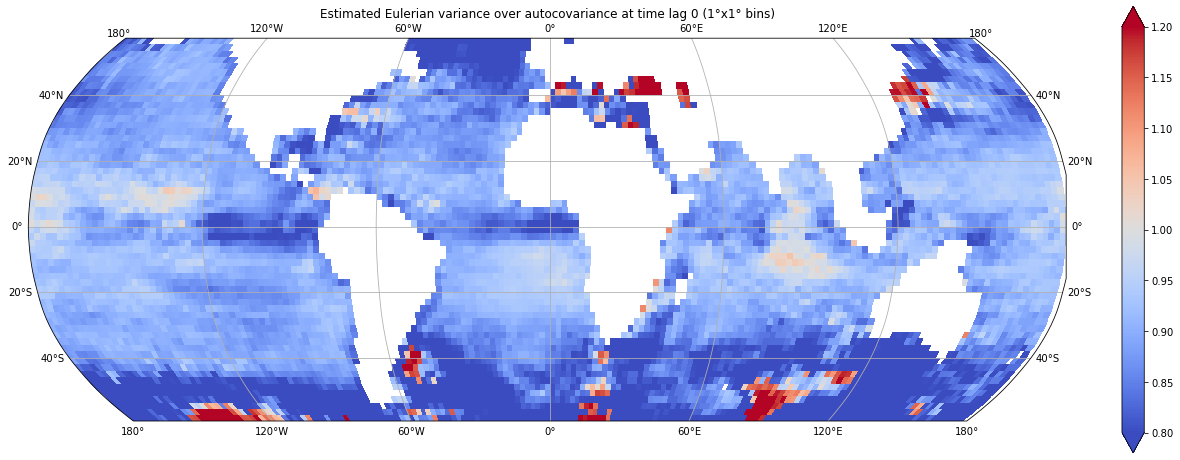

In [32]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Eulerian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

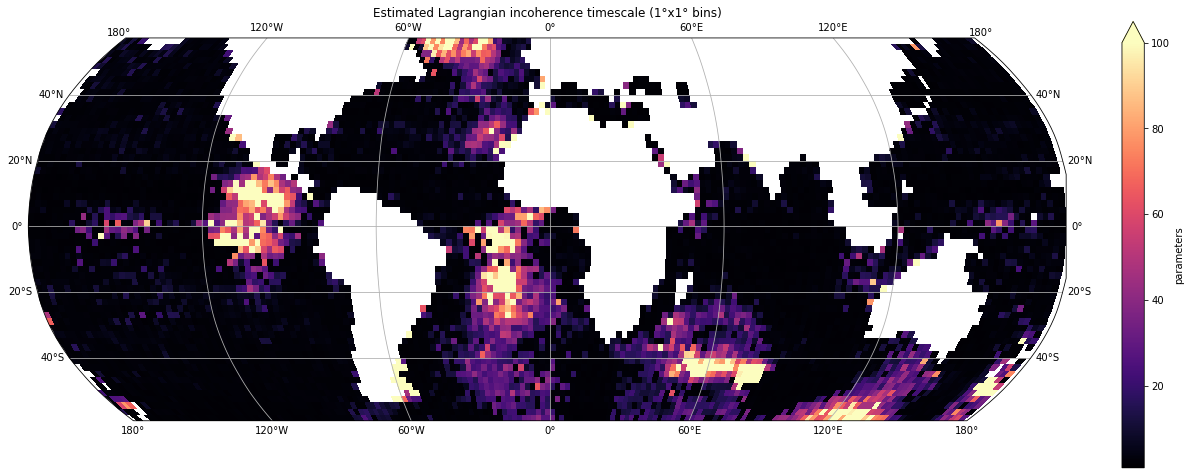

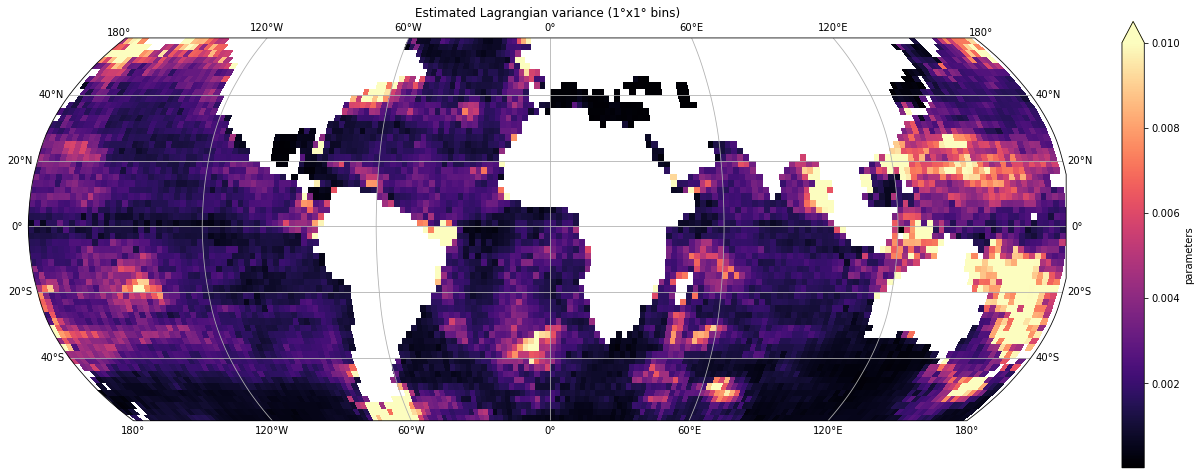

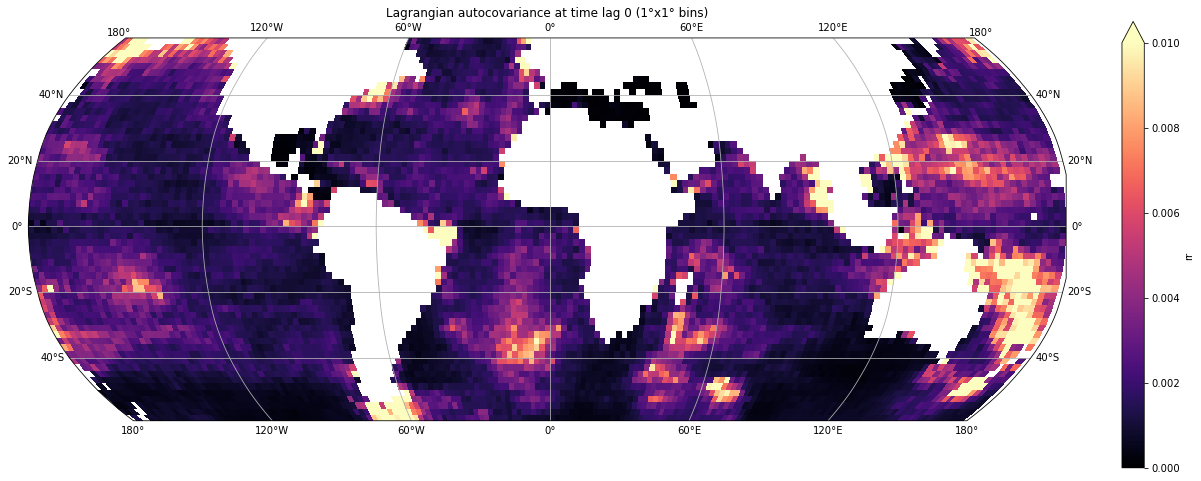

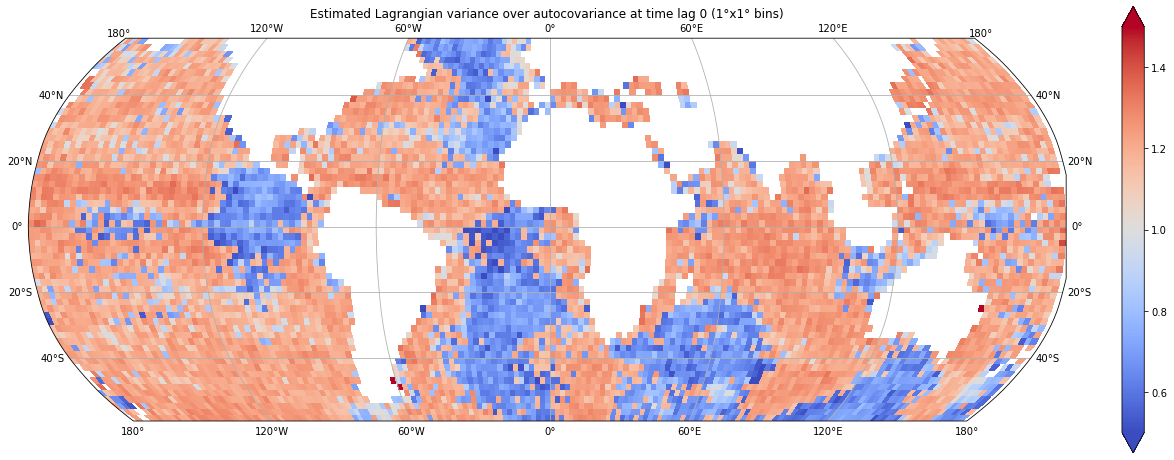

In [33]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Lagrangian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL.rr.isel(lags=0)
                   ,colmap='magma',vlim=(0,0.01))
ax.set_title('Lagrangian autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

#### Autocovariance form and corresponding best fit

In [34]:
# Area of interest
bbox_cal = [-125,35] #california
bbox_med = [4,40] # mediterranean sea
bbox_nwa = [115,-15] # North-west Australia
bbox_nea = [160,-15] # North-west Australia
bbox_swa = [120,-40] # South-west Australia
#bbox_neh = [-160, 35] # North-east Hawaii
bbox_eq = [-125,0] #equator
bbox_atl = [-10,-20]

#for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq,bbox_atl]:
#    ax.scatter(bbox[0],bbox[1],c='g',edgecolor='k',transform=ccrs.PlateCarree())

Text(0.5, 0.98, 'Lagrangian autocorrelation')

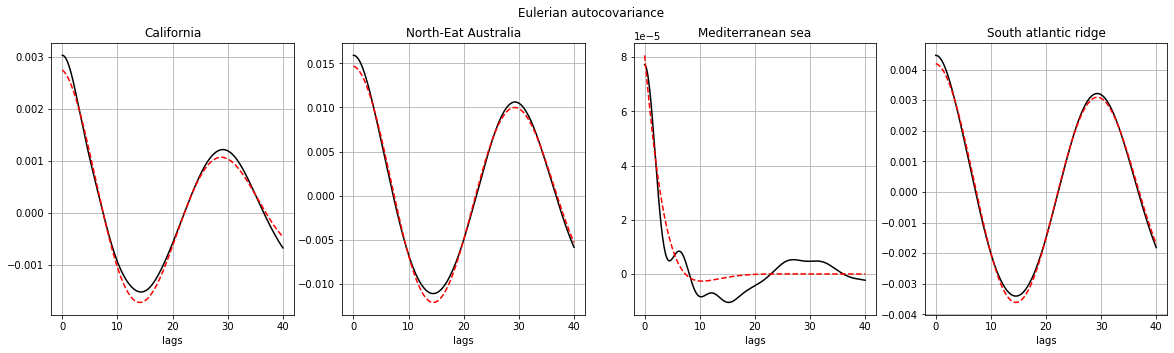

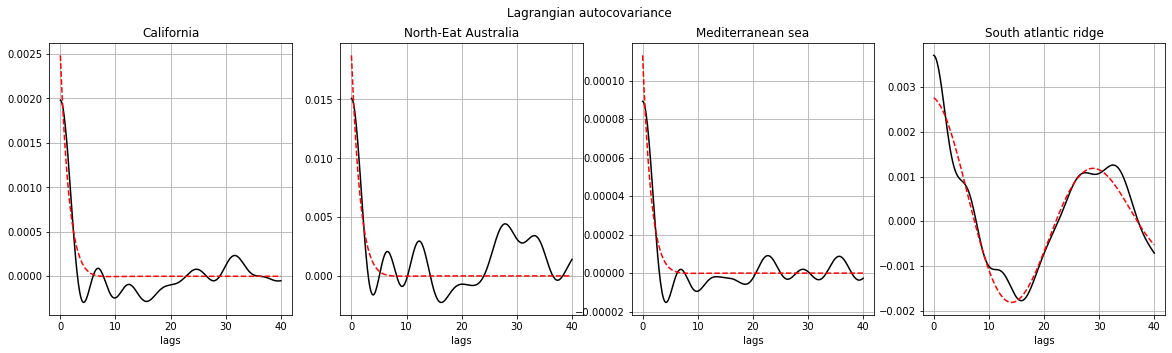

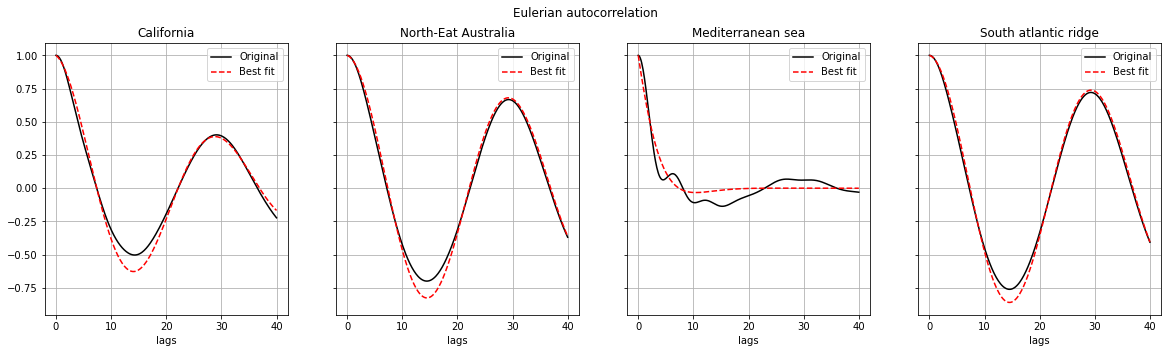

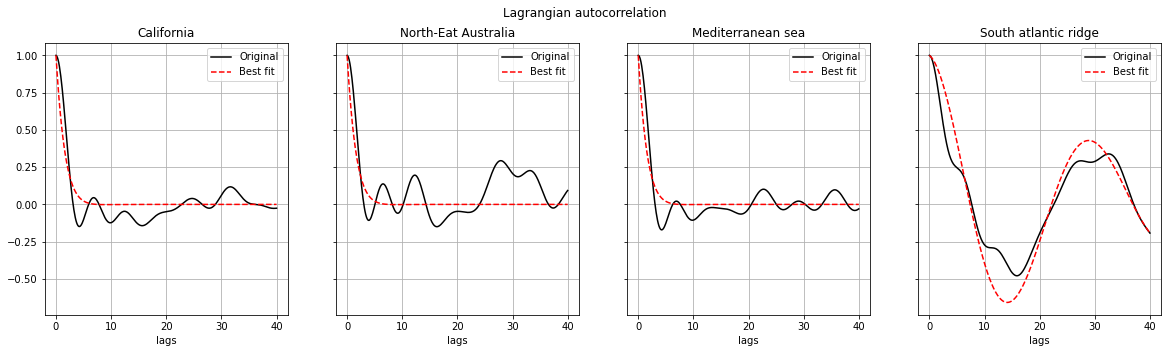

In [35]:
boxes = {'California':bbox_cal,'North-Eat Australia':bbox_nea,'Mediterranean sea':bbox_med,
         'South atlantic ridge':bbox_atl}
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5),sharey=True)
for ax, bbox in zip(axes,boxes):
    dsE.rr_norm.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr_norm.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend()
fig.suptitle('Eulerian autocorrelation')

fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5),sharey=True)
for ax, bbox in zip(axes,boxes):
    dsL.rr_norm.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr_norm.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend()
fig.suptitle('Lagrangian autocorrelation')

### Testing more complex fit

#### Using the autocovariance at $\tau=0$ as first guess for $\tilde V$

In [36]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,p0='lag',bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [37]:
dsL_out = wrapper(dsL,'rr',y_fit,tau,p0='lag',bounds=([-np.inf,-np.inf],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

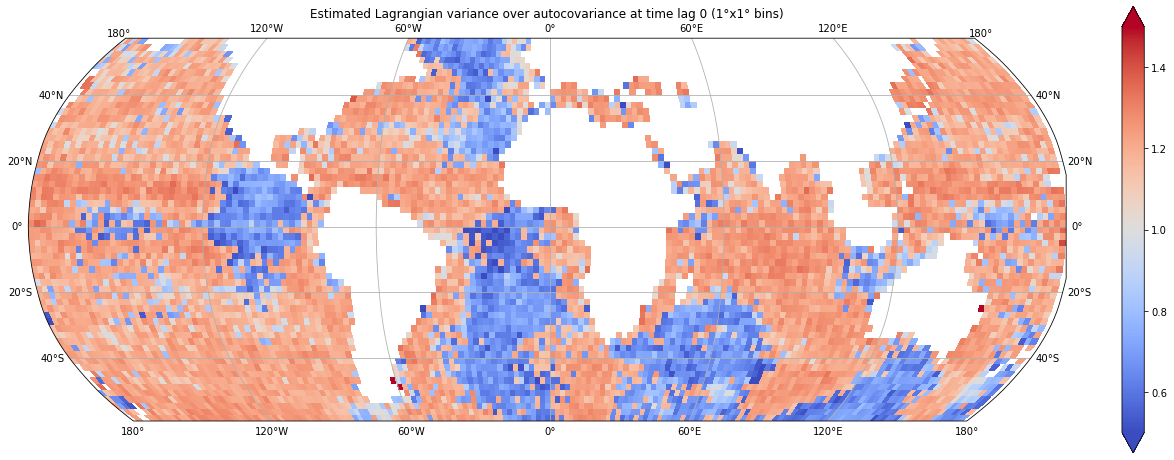

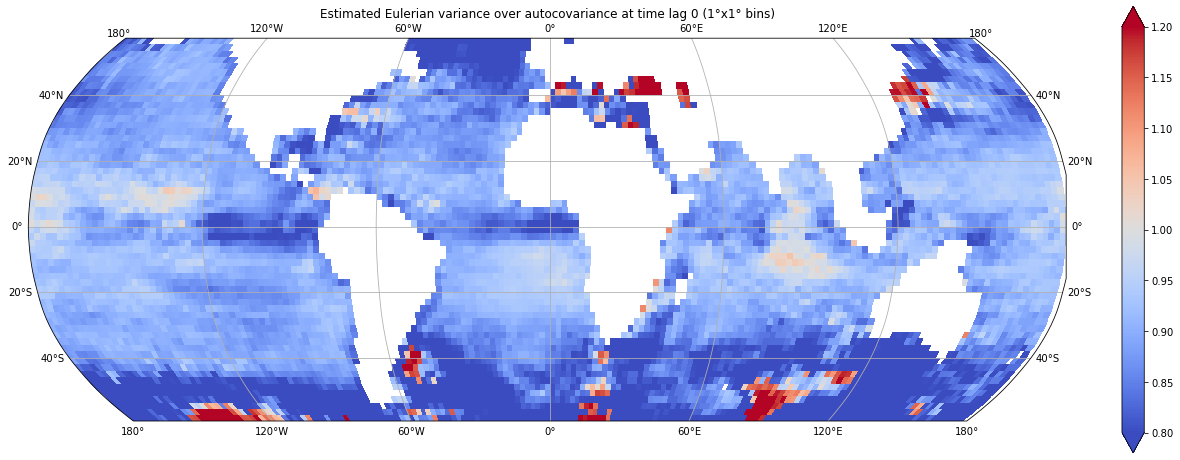

In [38]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 0.98, 'Lagrangian autocovariance')

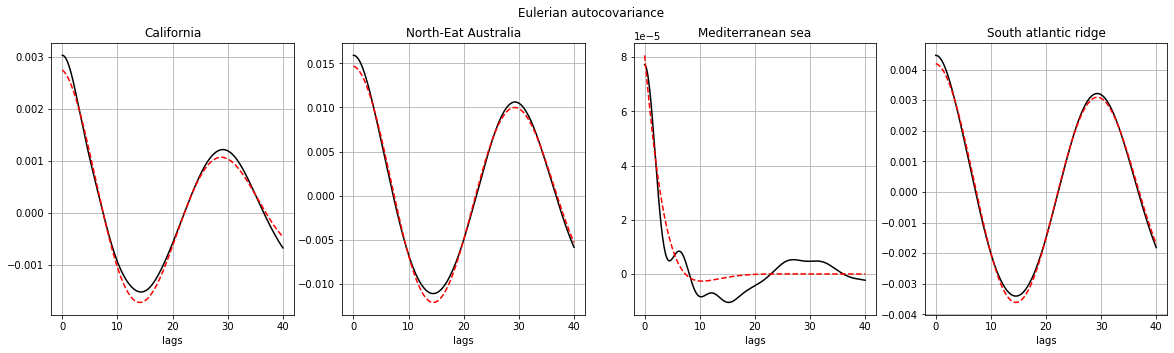

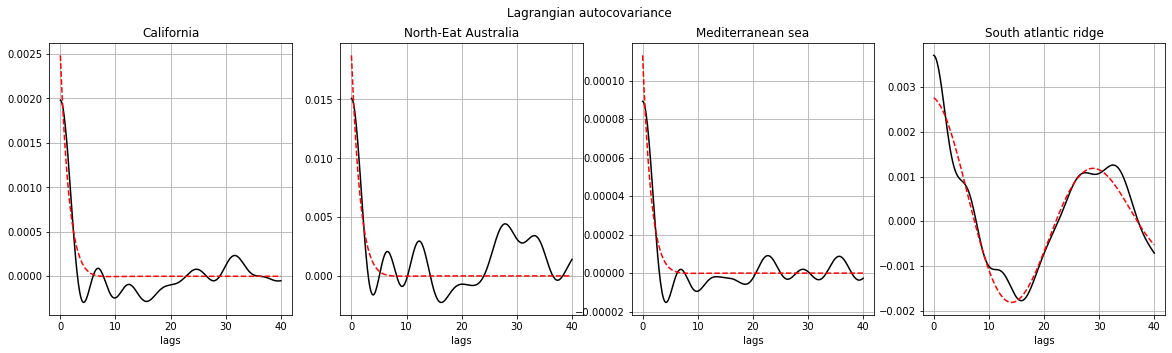

In [39]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

#### With bounds

In [40]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,p0='lag',bounds=([1,0],[2000,10]))

Parameters to estimate: ['T', 'V']


In [41]:
dsL_out = wrapper(dsL,'rr',y_fit,tau,p0='lag',bounds=([1,0],[2000,10]))

Parameters to estimate: ['T', 'V']


Text(0.5, 1.0, 'Estimated Lagrangian incoherence timescale (1°x1° bins)')

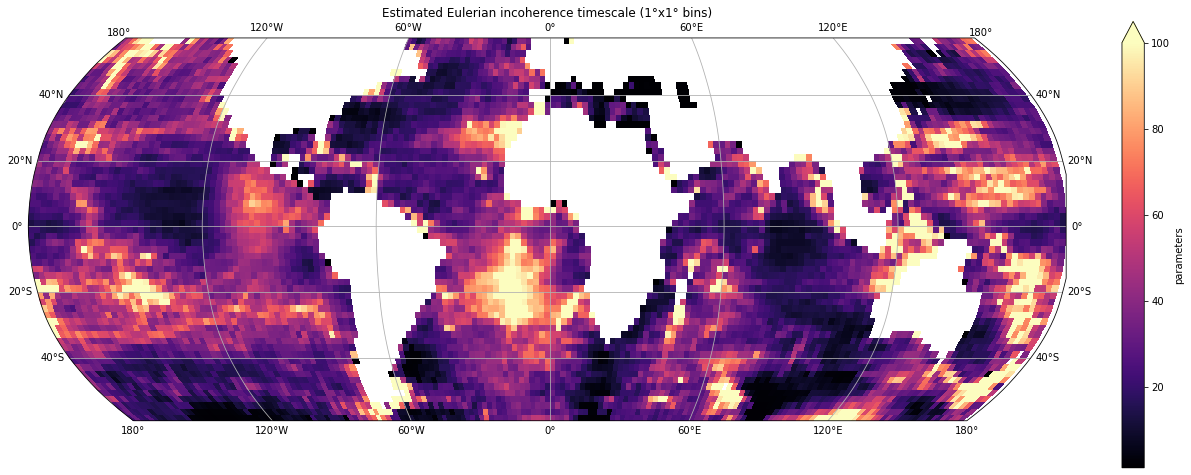

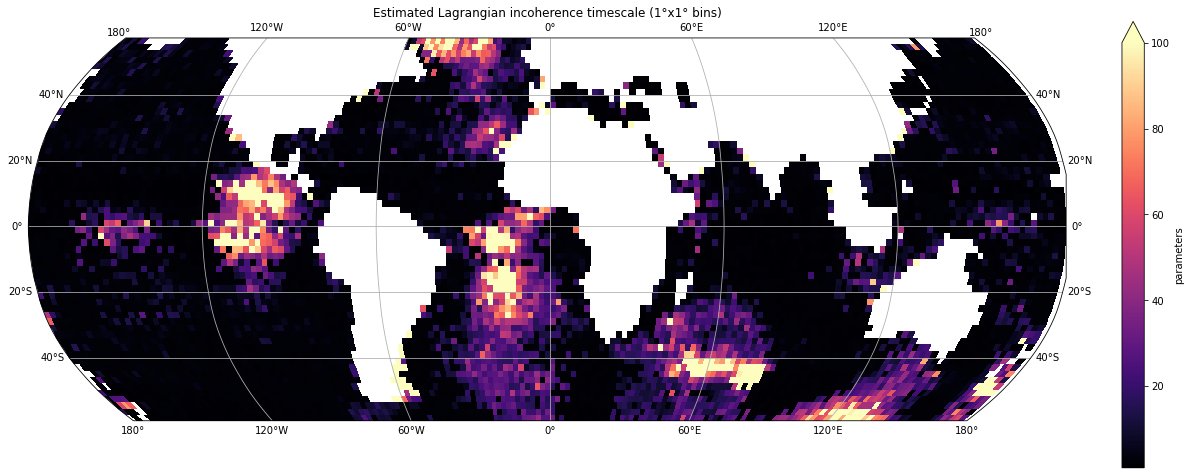

In [42]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

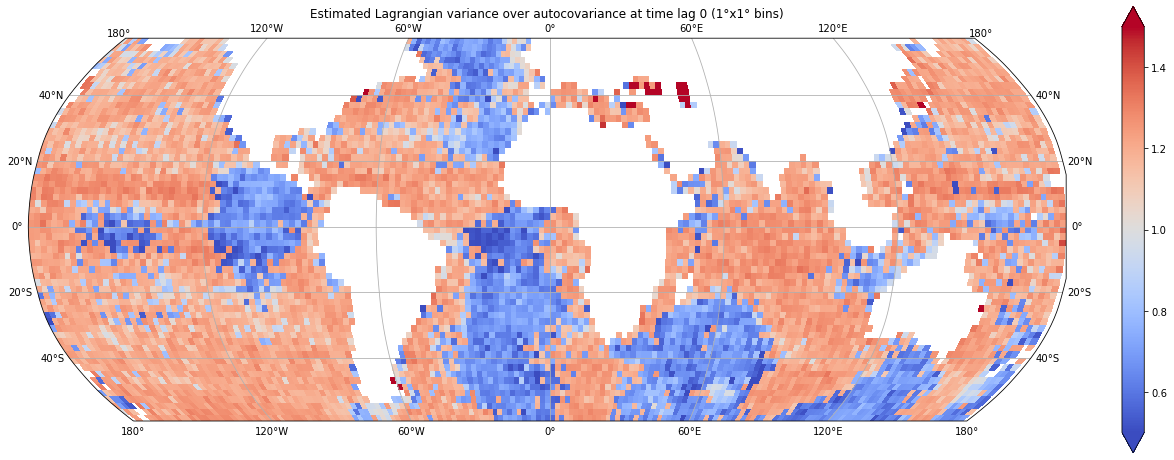

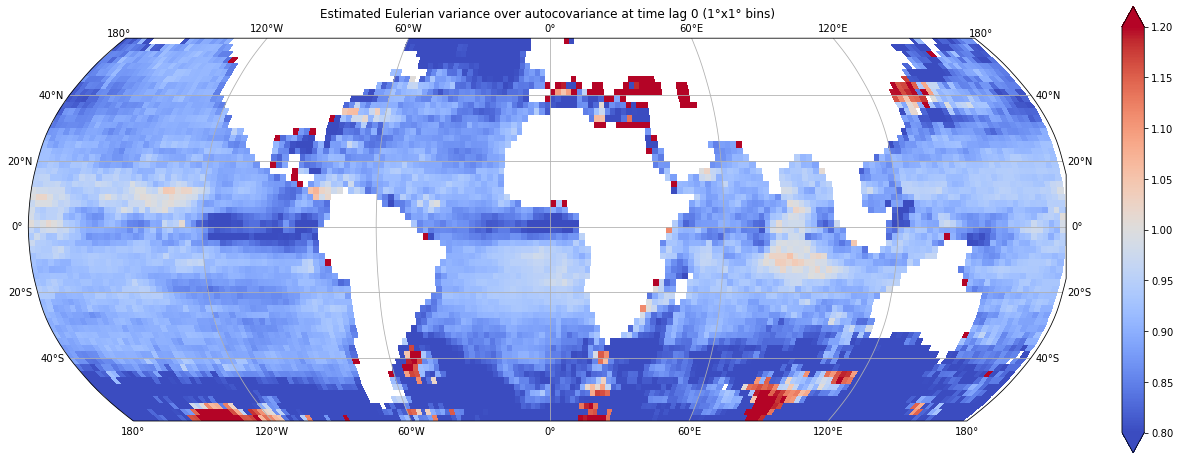

In [43]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 0.98, 'Lagrangian autocovariance')

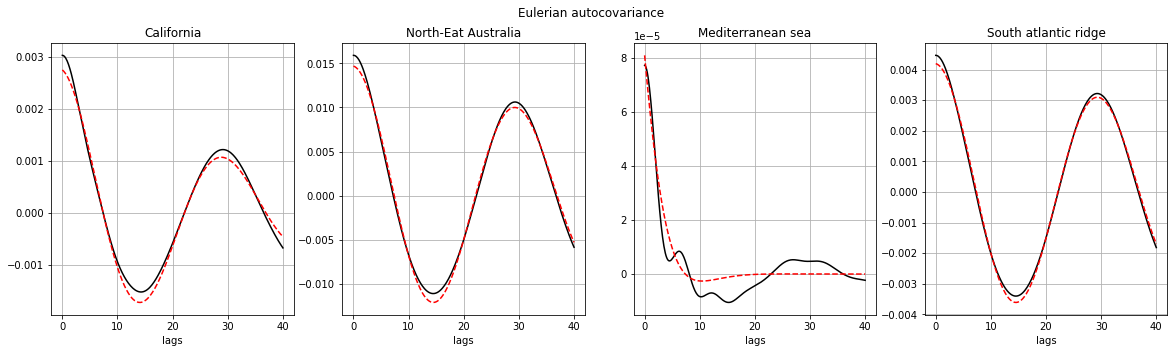

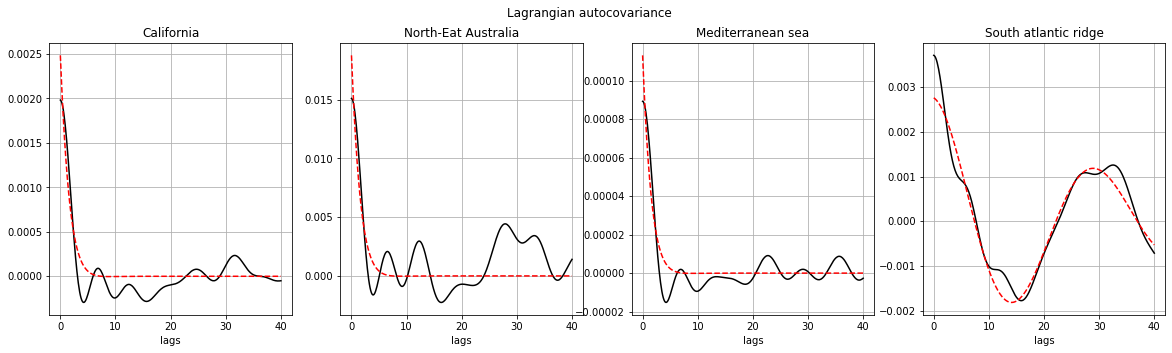

In [44]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

#### More weight on shorter time lags (20 days) and a lot on $\tau=0$

In [45]:
sigma = np.ones(tau.size)*0.5
sigma[int(20/dt):] = 10
sigma[0] = 0.1

In [46]:
dsE_out = wrapper(dsE,'rr',y_fit,tau,p0='lag',sigma=sigma,bounds=([0,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


In [47]:
dsL_out = wrapper(dsL,'rr',y_fit,tau,p0='lag',sigma=sigma,bounds=([0,0],[np.inf,np.inf]))

Parameters to estimate: ['T', 'V']


Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

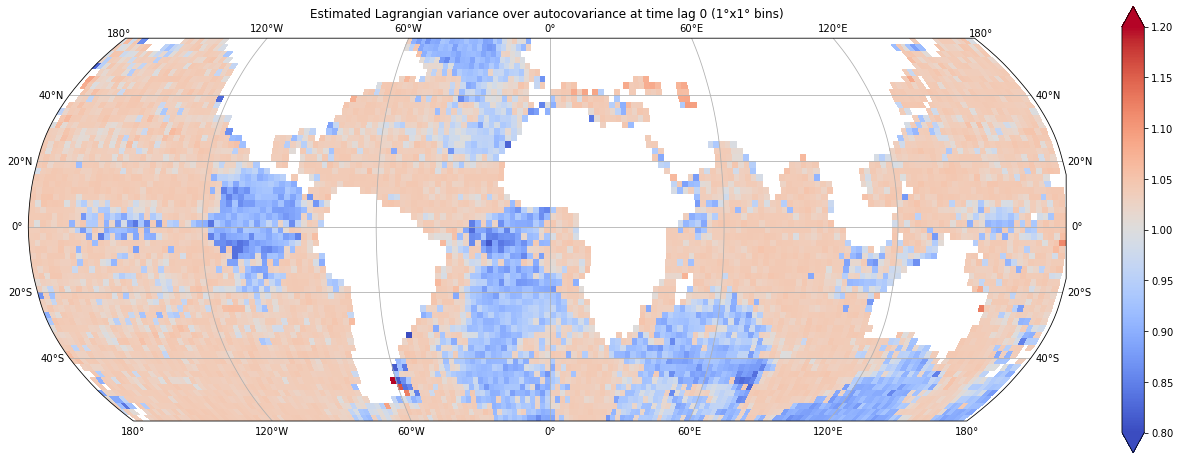

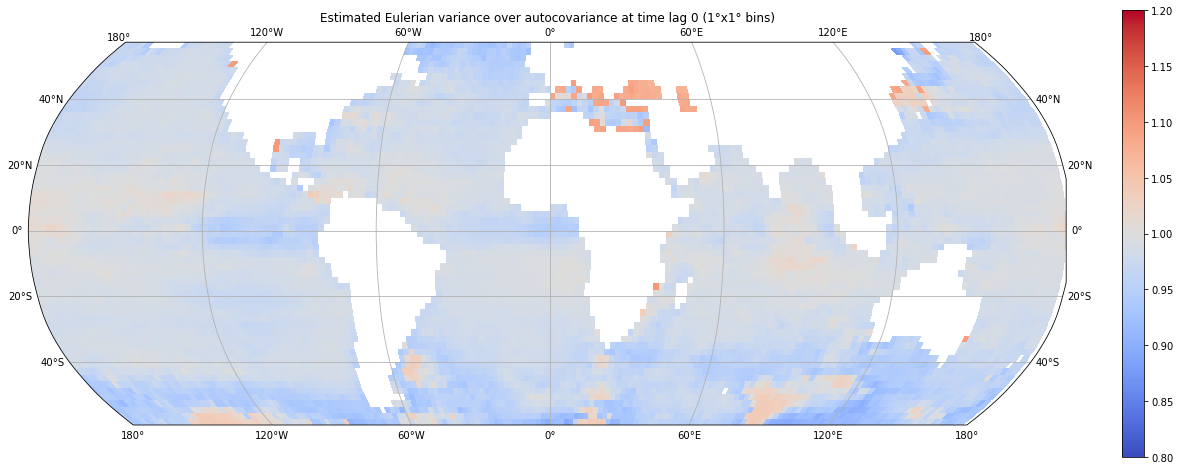

In [48]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 0.98, 'Lagrangian autocovariance')

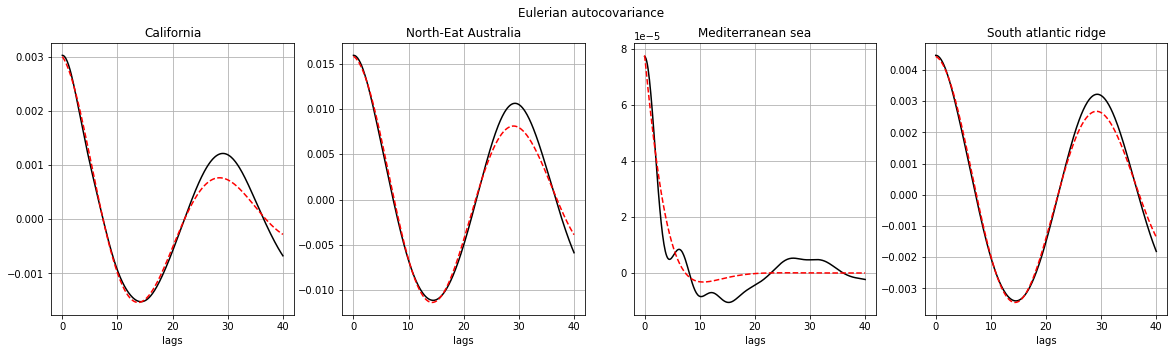

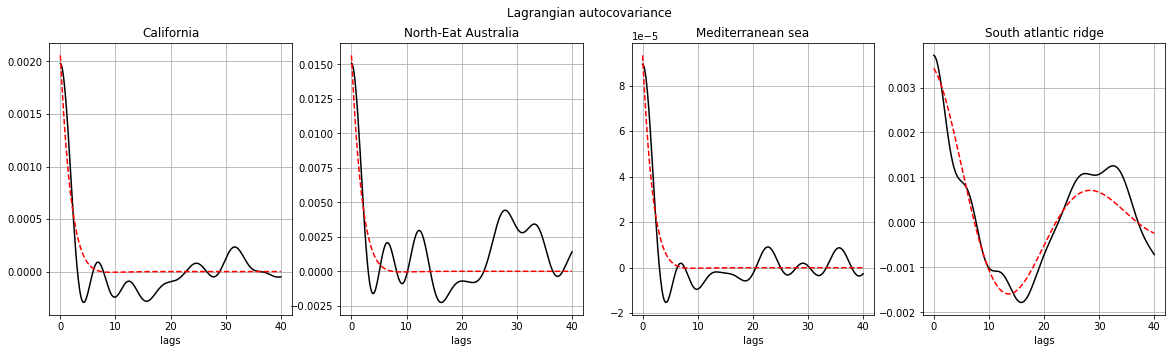

In [49]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

#### Other models : 
1) Shift

2) Fit to a model with shorter oscillations ($\omega\sim$7days)

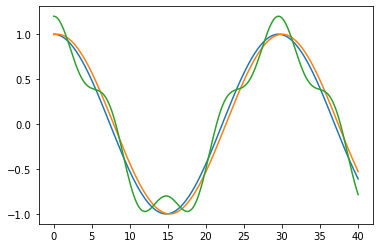

In [50]:
plt.plot(tau,np.cos(omega_sn*rad*tau))
phi=-0.1
plt.plot(tau,np.cos(omega_sn*rad*tau+phi))
#plt.plot(tau,np.cos(4*omega_sn*rad*tau))
plt.plot(tau,np.cos(omega_sn*rad*tau)+0.2*np.cos(4*omega_sn*rad*tau))

In [51]:
def y_shift(tau,phi,T,V):
    return V*np.exp(-tau/T)*np.cos(rad*omega_sn*tau+phi)

def y_osc(tau,Vsmall,omega,T,V):
    return V*np.cos(omega_sn*rad*tau)*np.exp(-tau/T)+Vsmall*np.cos(omega*rad*tau)

def y_osc_v1(tau,Vsmall,T,V):
    return V*np.cos(omega_sn*rad*tau)*np.exp(-tau/T)+Vsmall*np.cos(4*omega_sn*rad*tau)

def y_osc_v2(tau,Vsmall,omega,T,V):
    return (V*np.cos(omega_sn*rad*tau)+Vsmall*np.cos(omega*rad*tau))*np.exp(-tau/T)

def y_osc_v3(tau,Vsmall,Tsmall,omega,T,V):
    return V*np.exp(-tau/T)*np.cos(omega_sn*rad*tau)+Vsmall*np.exp(-tau/Tsmall)*np.cos(omega*rad*tau)



#### Shift

In [52]:
dsE_out = wrapper(dsE,'rr',y_shift,tau,bounds=([-omega_sn*rad,0,0],[omega_sn*rad,np.inf,10]))

Parameters to estimate: ['phi', 'T', 'V']


In [53]:
dsL_out = wrapper(dsL,'rr',y_shift,tau,bounds=([-omega_sn*rad,0,0],[omega_sn*rad,np.inf,10]))

Parameters to estimate: ['phi', 'T', 'V']


Text(0.5, 1.0, 'Estimated Lagrangian incoherence timescale (1°x1° bins)')

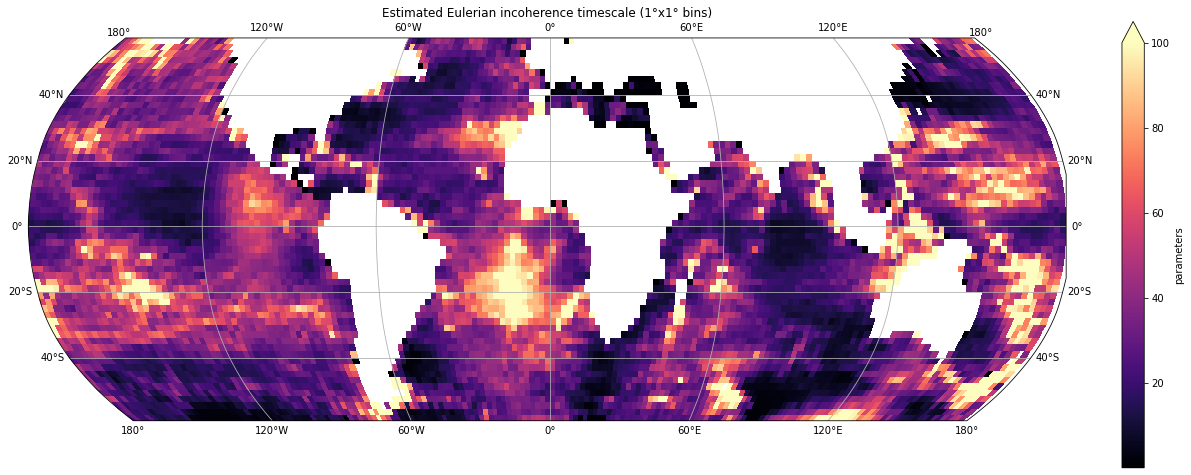

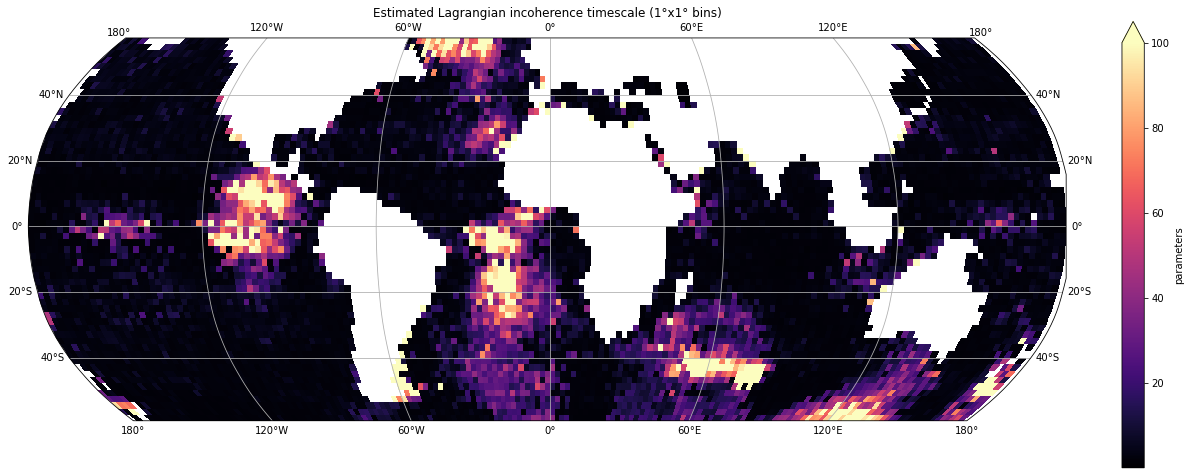

In [54]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Eulerian incoherence timescale (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,100))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian shift (1°x1° bins)')

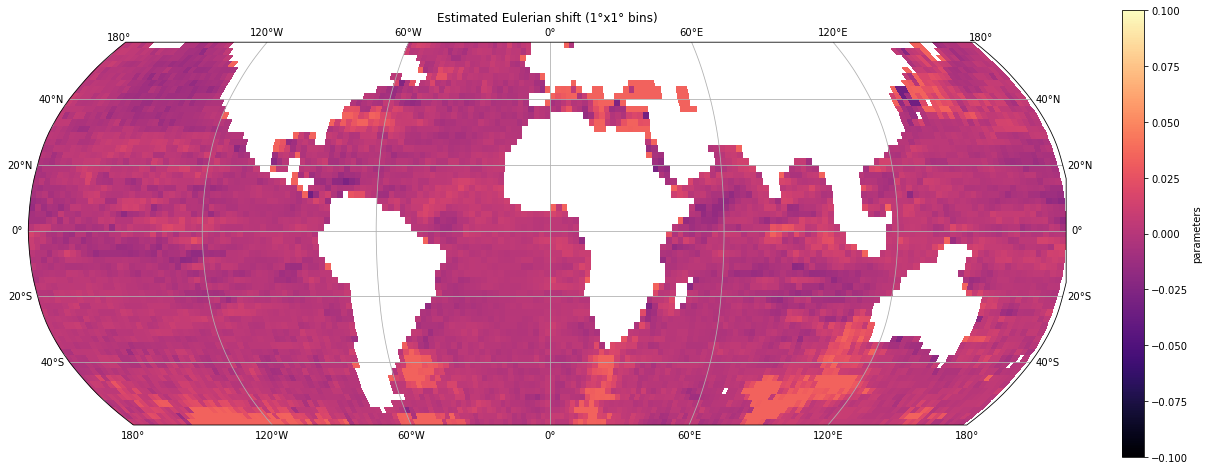

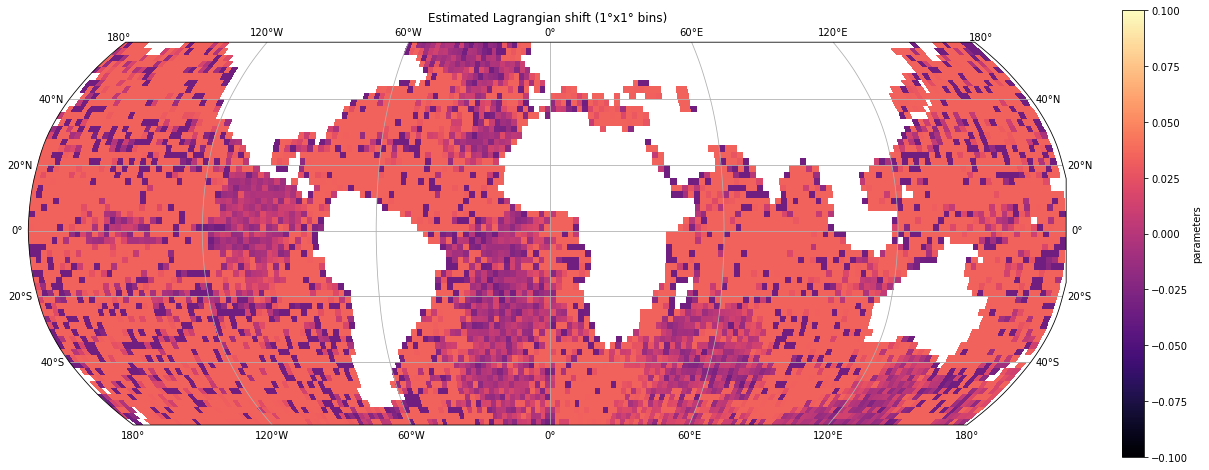

In [55]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'phi').parameters/(2*np.pi)),colmap='magma',vlim=(None,0.1))
ax.set_title('Estimated Eulerian shift (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'phi').parameters/(2*np.pi)),colmap='magma',vlim=(None,0.1))
ax.set_title('Estimated Lagrangian shift (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian variance (1°x1° bins)')

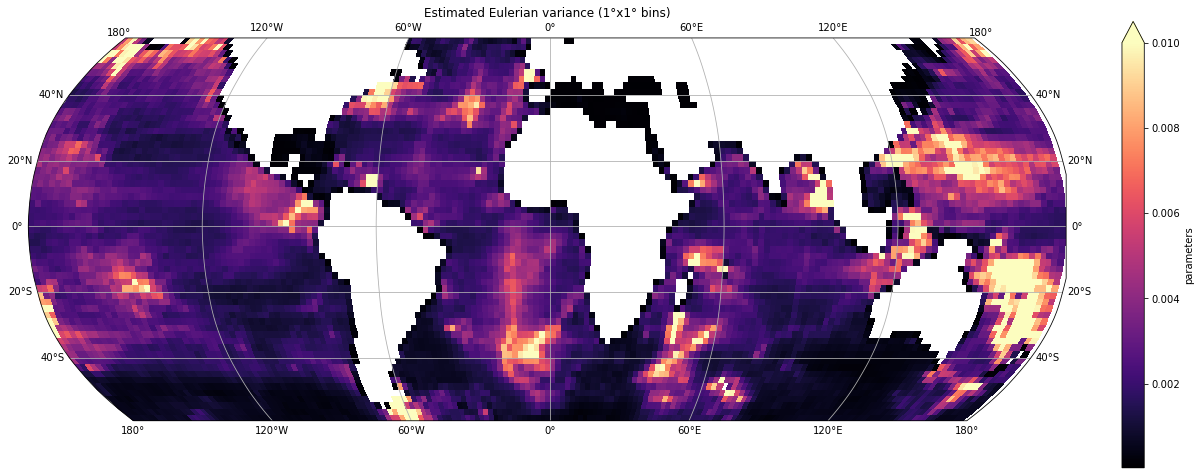

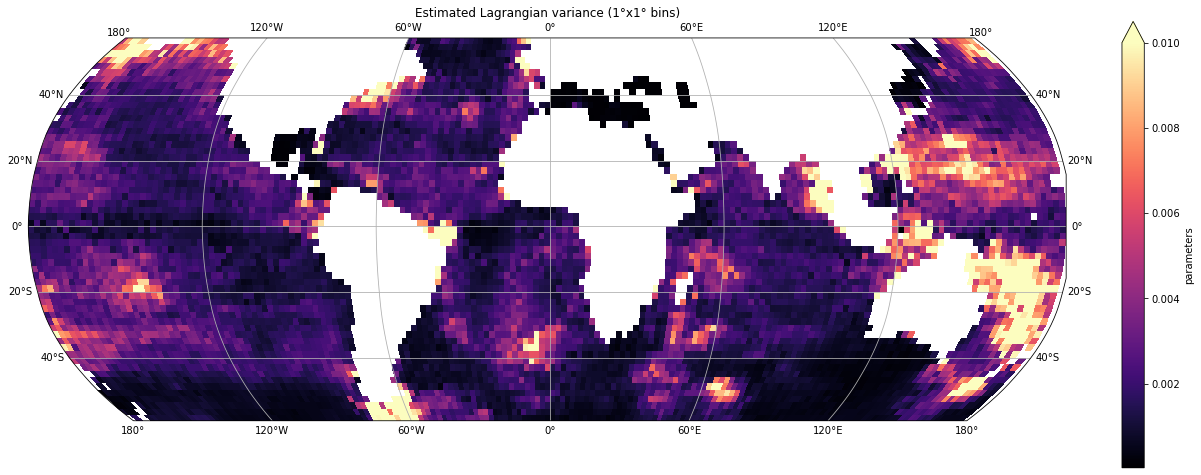

In [56]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Eulerian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Lagrangian variance (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

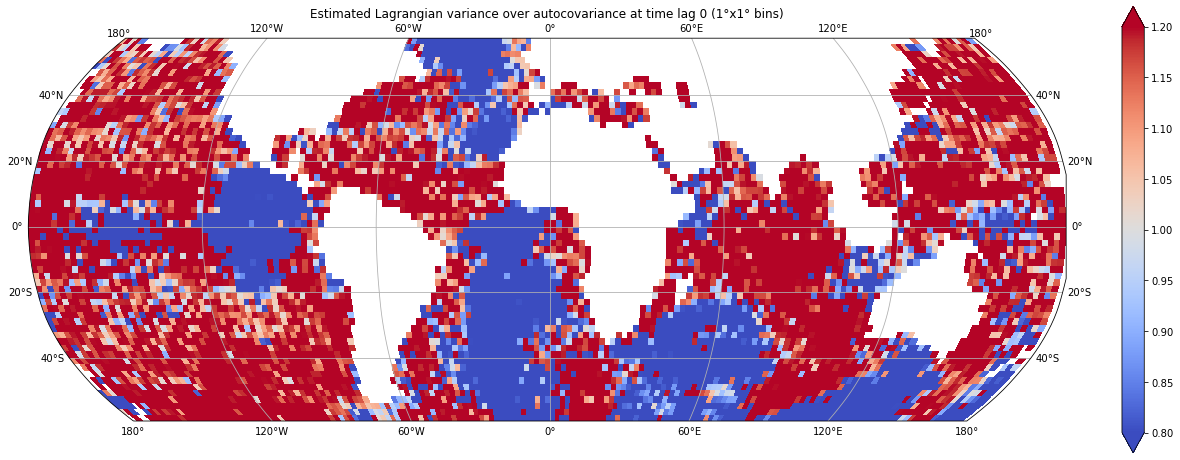

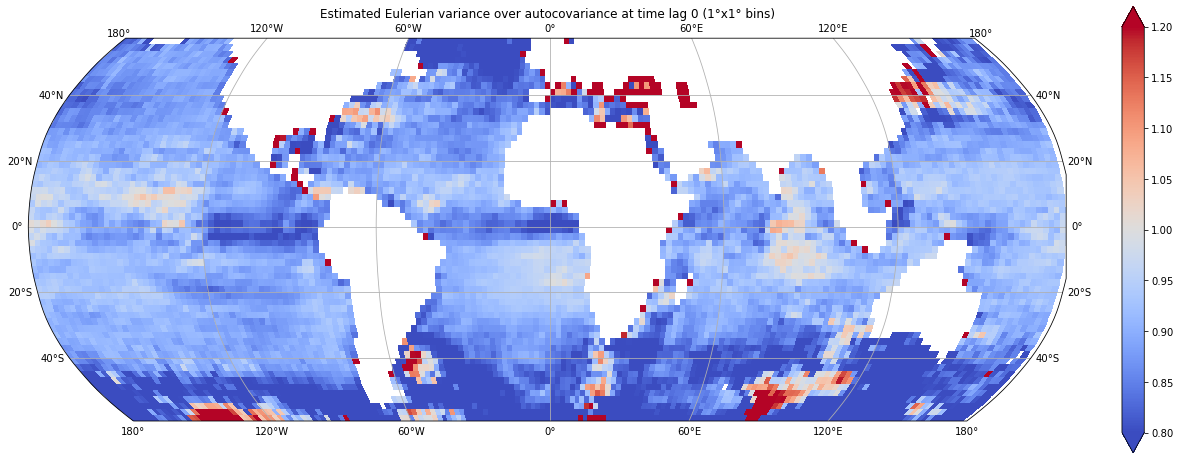

In [57]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_out.sel(param = 'V').parameters/dsL.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Lagrangian variance over autocovariance at time lag 0 (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_out.sel(param = 'V').parameters/dsE.rr.isel(lags=0))
                   ,colmap='coolwarm',vlim=(0.8,1.2))
ax.set_title('Estimated Eulerian variance over autocovariance at time lag 0 (1°x1° bins)')

Text(0.5, 0.98, 'Lagrangian autocovariance')

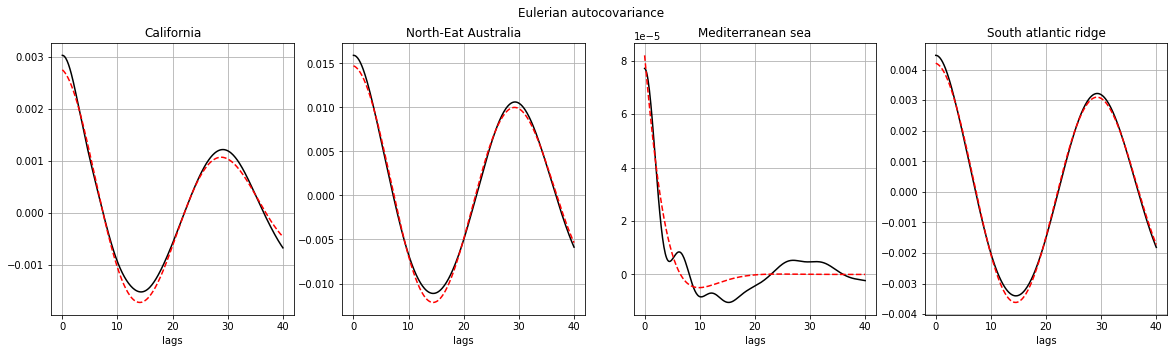

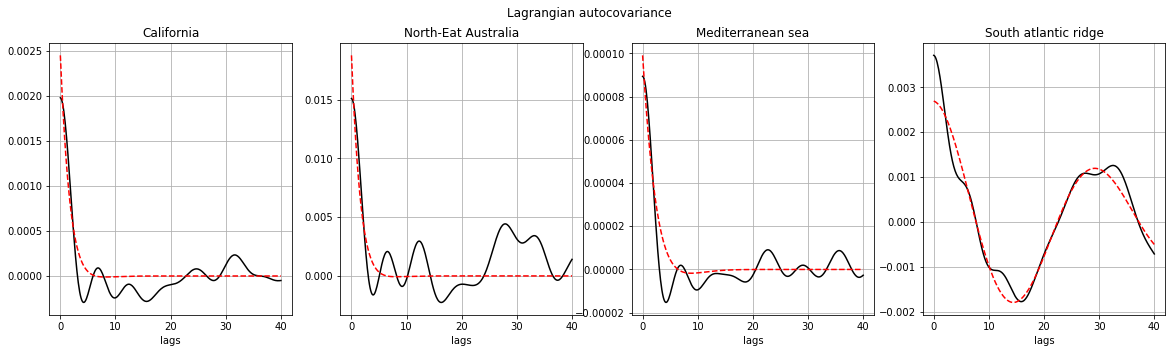

In [58]:
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsE_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    dsL_out.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='r',linestyle='--',label='Best fit')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);
fig.suptitle('Lagrangian autocovariance')

##### Small oscillations (unknown cause)

In [59]:
dsE_out = wrapper(dsE,'rr',y_osc,tau,bounds=([0,0,0,0],[10,1/10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'omega', 'T', 'V']


In [60]:
dsL_out = wrapper(dsL,'rr',y_osc,tau,bounds=([0,0,0,0],[10,1/10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'omega', 'T', 'V']


In [61]:
dsE_out_v1 = wrapper(dsE,'rr',y_osc_v1,tau,bounds=([0,0,0],[10,np.inf,10]))
dsL_out_v1 = wrapper(dsL,'rr',y_osc_v1,tau,bounds=([0,0,0],[10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'T', 'V']
Parameters to estimate: ['Vsmall', 'T', 'V']


In [62]:
dsE_out_v2 = wrapper(dsE,'rr',y_osc_v2,tau,bounds=([0,0,0,0],[10,1/10,np.inf,10]))
dsL_out_v2 = wrapper(dsL,'rr',y_osc_v2,tau,bounds=([0,0,0,0],[10,1/10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'omega', 'T', 'V']
Parameters to estimate: ['Vsmall', 'omega', 'T', 'V']


In [63]:
dsE_out_v3 = wrapper(dsE,'rr',y_osc_v3,tau,bounds=([0,0,0,0,0],[10,np.inf,1/10,np.inf,10]))
dsL_out_v3 = wrapper(dsL,'rr',y_osc_v3,tau,bounds=([0,0,0,0,0],[10,np.inf,1/10,np.inf,10]))

Parameters to estimate: ['Vsmall', 'Tsmall', 'omega', 'T', 'V']
Parameters to estimate: ['Vsmall', 'Tsmall', 'omega', 'T', 'V']


Text(0.5, 0.98, 'Lagrangian autocovariance')

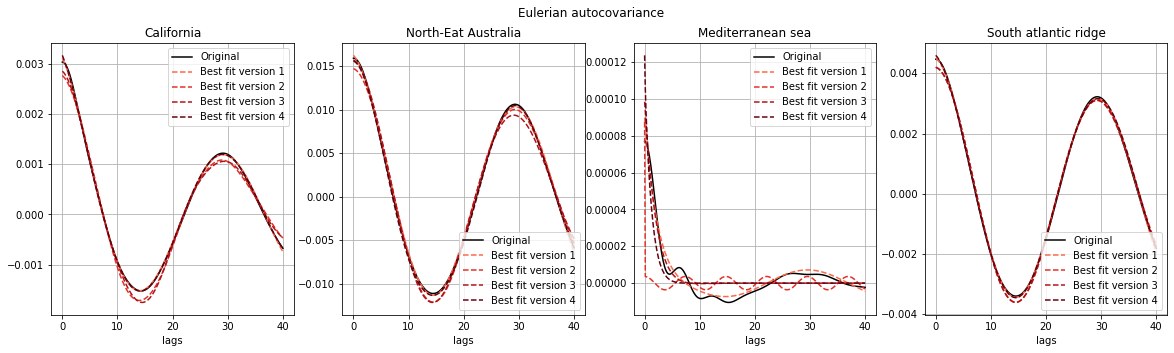

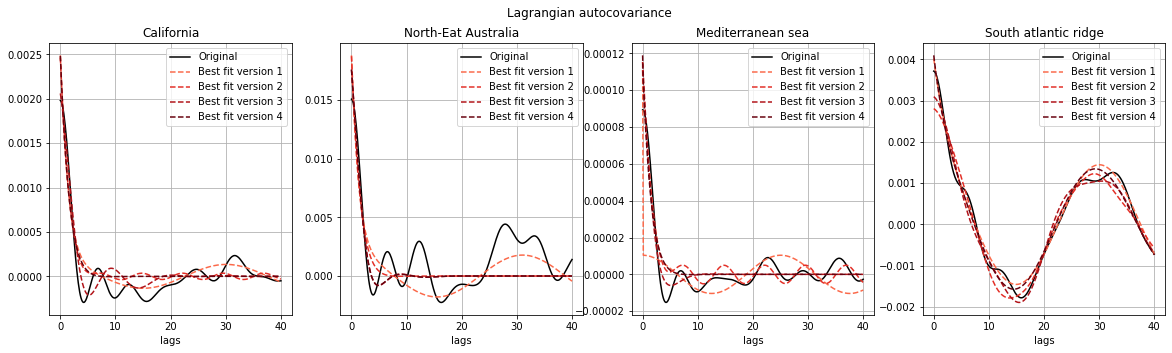

In [64]:
#colors = ['maroon','firebrick','r']
colors = plt.cm.Reds(np.linspace(0.5, 1, 4))
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsE.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    for i,ds_fit in enumerate([dsE_out,dsE_out_v1,dsE_out_v2,dsE_out_v3]):
        c = colors[i]
        ds_fit.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                      ).plot(ax=ax,c=c,linestyle='--',label='Best fit version %s'%str(i+1))
   # dsE_out_v2.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
   #               ).plot(ax=ax,c='firebrick',linestyle='--',label='Best fit version 2')
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend();
fig.suptitle('Eulerian autocovariance')
    
fig,axes = plt.subplots(1,len(boxes),figsize=(5*len(boxes),5))
for ax, bbox in zip(axes,boxes):
    dsL.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                  ).plot(ax=ax,c='k',label='Original')
    for i,ds_fit in enumerate([dsL_out,dsL_out_v1,dsL_out_v2,dsL_out_v3]):
        c = colors[i]
        ds_fit.rr.sel(lat_bins=boxes[bbox][1],lon_bins=boxes[bbox][0],method='nearest'
                      ).plot(ax=ax,c=c,linestyle='--',label='Best fit version %s'%str(i+1))
    ax.set_ylabel('');ax.grid();ax.set_title(bbox);ax.legend();
fig.suptitle('Lagrangian autocovariance')

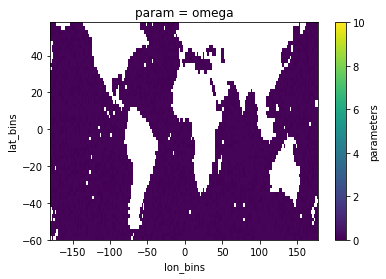

In [65]:
dsL_out_v3.parameters.sel(param='omega').plot(vmax=10)

In [66]:
def y_alpha(tau,alpha,T,V):
    return V*(alpha+(1-alpha)*np.exp(-tau/T))*np.cos(omega_sn*rad*tau)

In [67]:
dsL_out = wrapper(dsL,'rr',y_alpha,tau,bounds=([0,0,0],[1,np.inf,10]))

Parameters to estimate: ['alpha', 'T', 'V']


In [68]:
dsL_out_80 = wrapper(dsL_80,'rr',y_alpha,tau80,bounds=([0,0,0],[1,np.inf,10]))

Parameters to estimate: ['alpha', 'T', 'V']


In [71]:
dsE_out = wrapper(dsE,'rr',y_alpha,tau,bounds=([0,0,0],[1,np.inf,10]))

Parameters to estimate: ['alpha', 'T', 'V']


Text(0.5, 1.0, 'Estimated Eulerian incoherence timescale (1°x1° bins)')

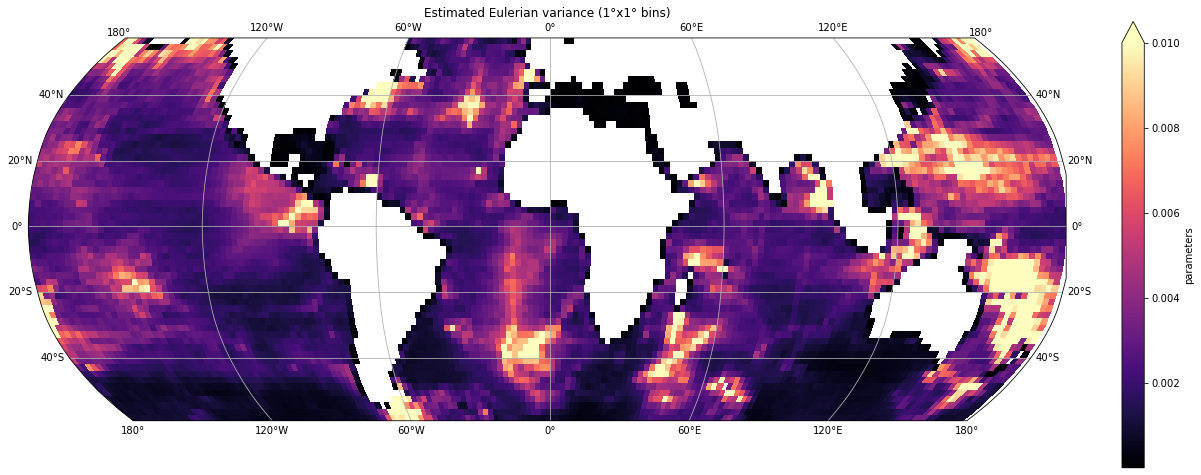

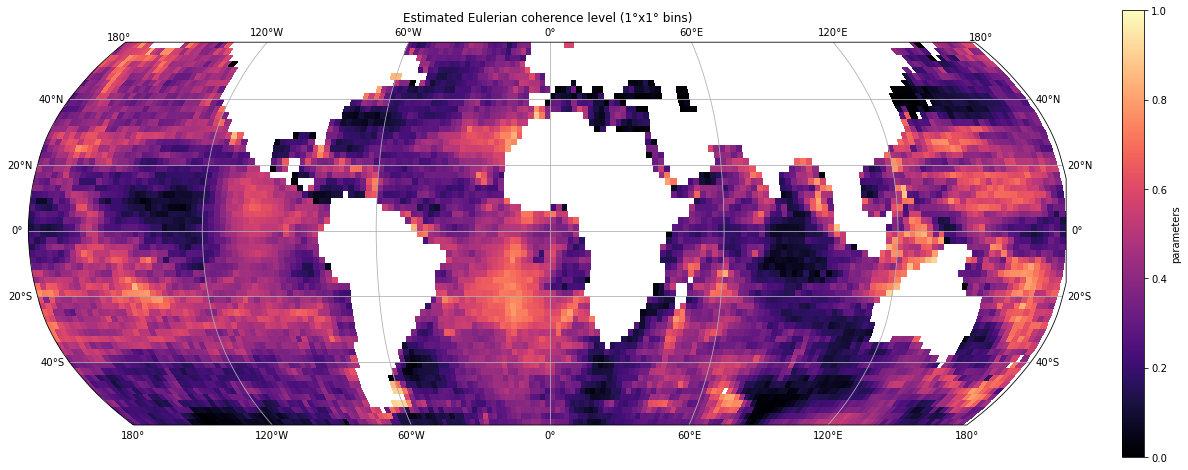

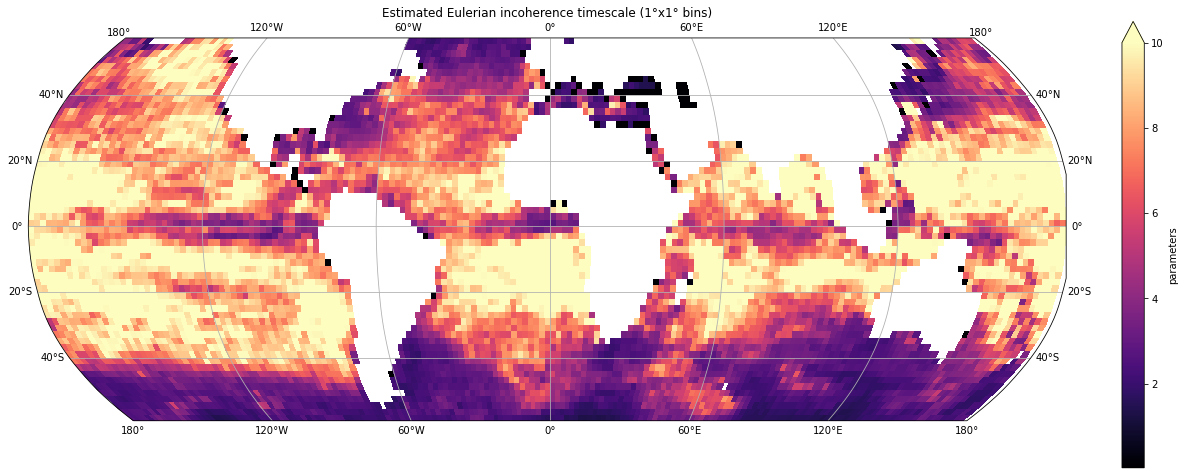

In [72]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Eulerian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'alpha').parameters,colmap='magma',vlim=(None,1))
ax.set_title('Estimated Eulerian coherence level (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,10))
ax.set_title('Estimated Eulerian incoherence timescale (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian incoherence timescale (1°x1° bins)')

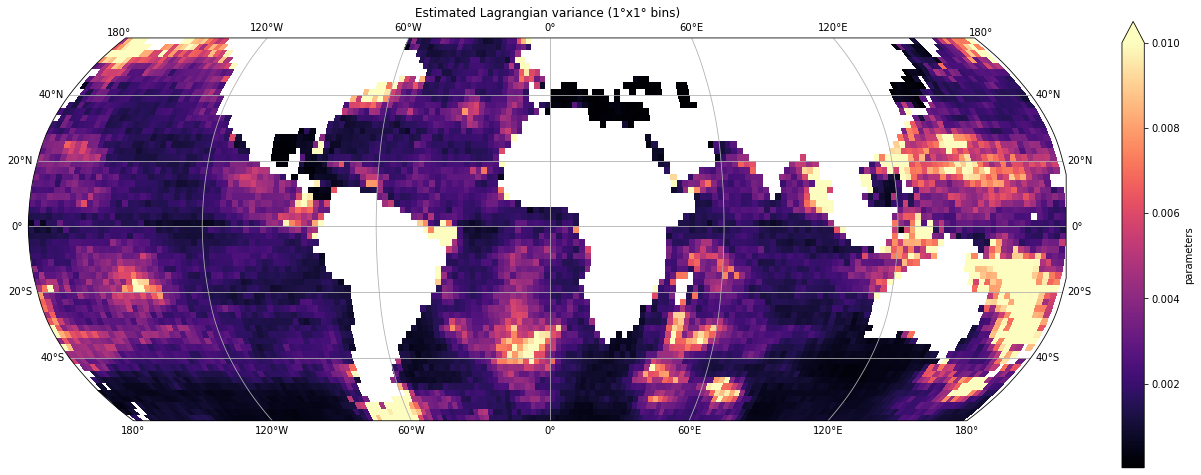

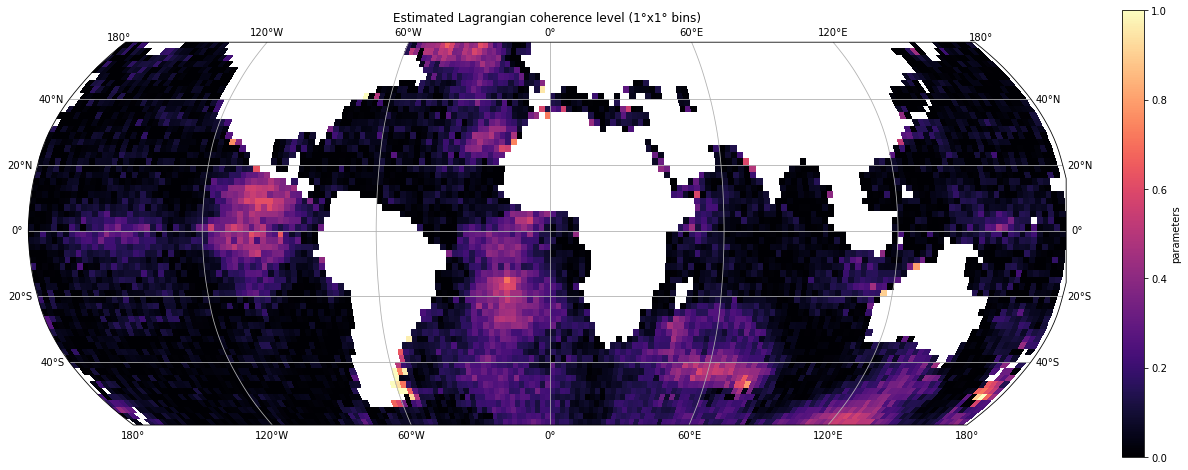

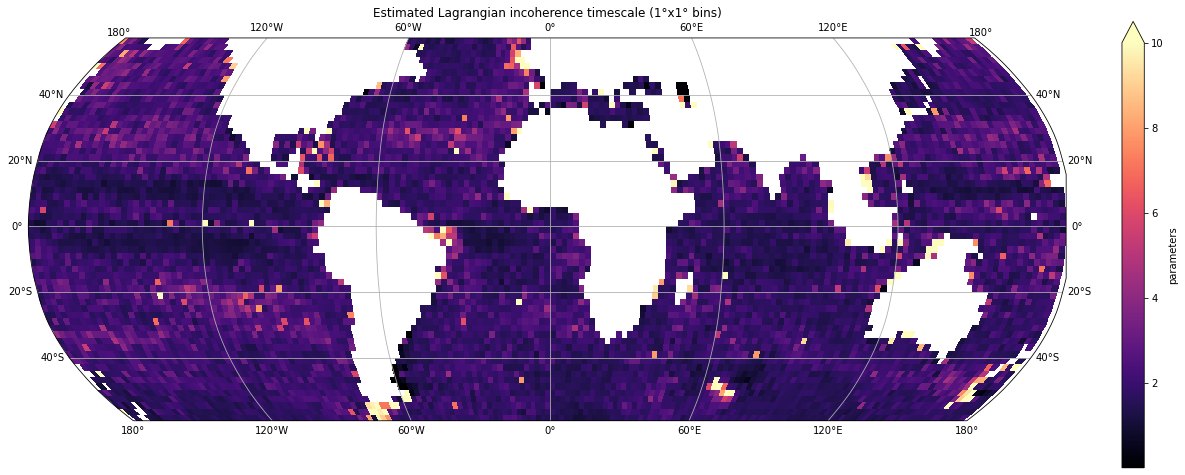

In [69]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Lagrangian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'alpha').parameters,colmap='magma',vlim=(None,1))
ax.set_title('Estimated Lagrangian coherence level (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out.sel(param = 'T').parameters,colmap='magma',vlim=(None,10))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

Text(0.5, 1.0, 'Estimated Lagrangian incoherence timescale (1°x1° bins)')

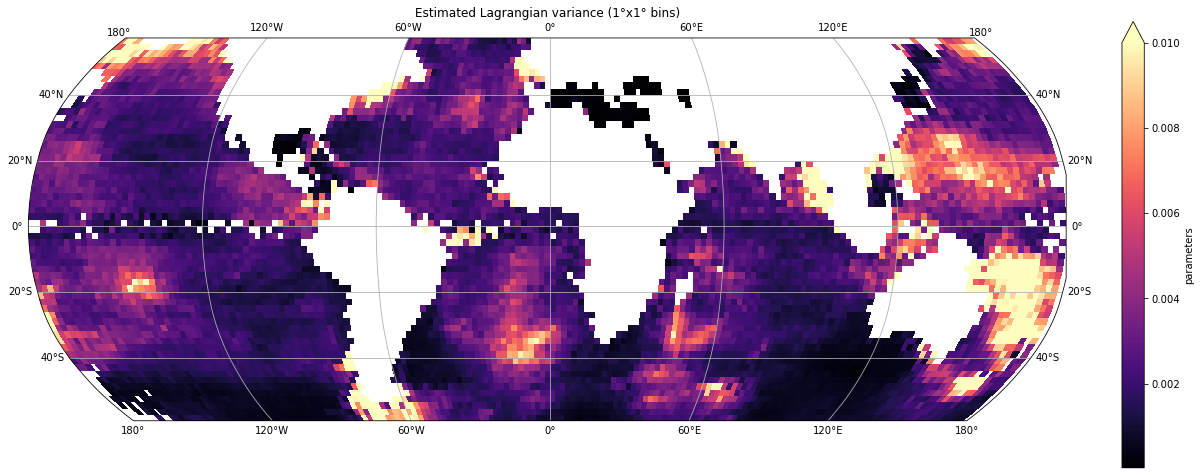

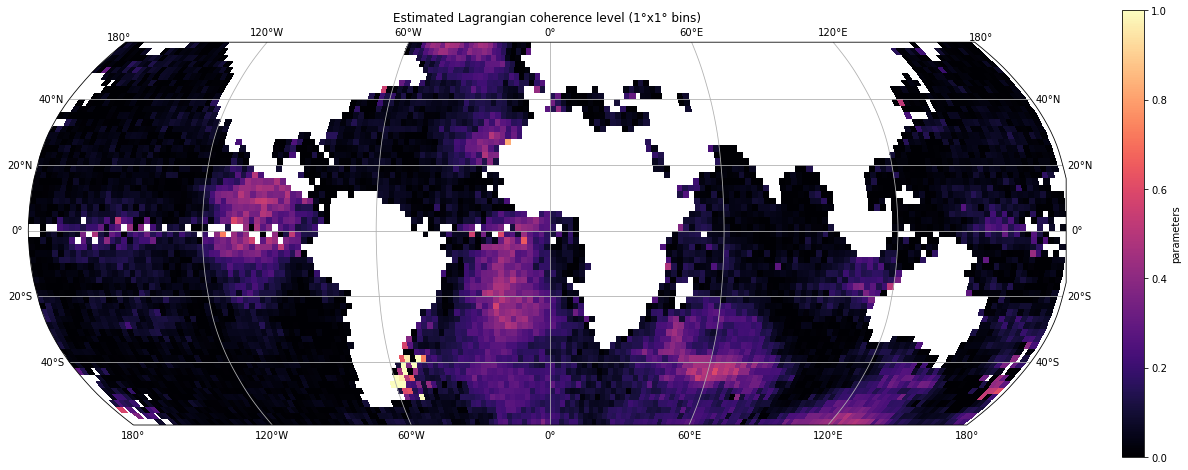

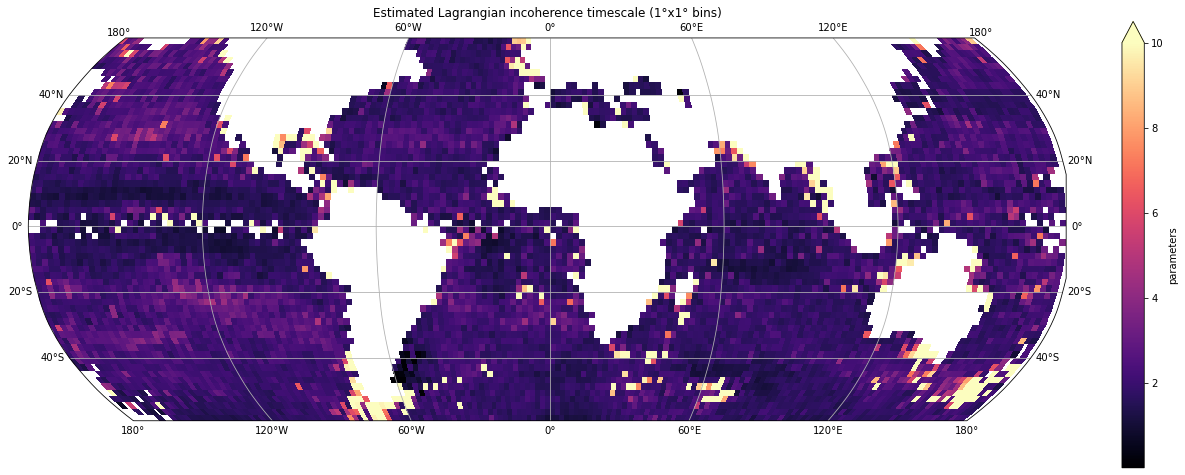

In [70]:
figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out_80.sel(param = 'V').parameters,colmap='magma',vlim=(None,0.01))
ax.set_title('Estimated Lagrangian variance (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out_80.sel(param = 'alpha').parameters,colmap='magma',vlim=(None,1))
ax.set_title('Estimated Lagrangian coherence level (1°x1° bins)')

figsize = (20,20)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_out_80.sel(param = 'T').parameters,colmap='magma',vlim=(None,10))
ax.set_title('Estimated Lagrangian incoherence timescale (1°x1° bins)')

In [73]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


# 